# Inference on an Ising Grid: Graphical Models vs GNNs

This notebook compares **Mean-Field (MF)**, **Belief Propagation (BP)**, and **Graph Neural Networks (GNNs)** on a partially observed Ising model defined on a 2D grid.

The goal is not performance tuning, but *conceptual comparison*: how analytical inference methods relate to learned message passing.

All figures produced by this notebook are saved to `figs/` for direct inclusion in the book.

## Setup and reproducibility
We begin by importing libraries, fixing random seeds, and creating the output directory for figures.

## Ising model and data generation
We define an Ising model on a 2D grid and generate a single ground-truth configuration using Gibbs sampling. This configuration serves as the hidden state to be inferred.

## Mean-field inference
We apply iterative mean-field updates, clamping observed nodes to their known values and updating the remaining marginals until convergence.

## Belief propagation
Next, we apply belief propagation (or a MAP-style message-passing proxy) to infer the most likely configuration consistent with observations.

## Graph Neural Network inference
Here we define and train a Graph Neural Network directly on the observed nodes of the single Ising instance. The GNN learns a message-passing rule that propagates label information across the grid.

## Visualization and comparison
We now visualize the ground truth, observations, and inferred configurations side by side. The resulting figure is saved for inclusion in the book.

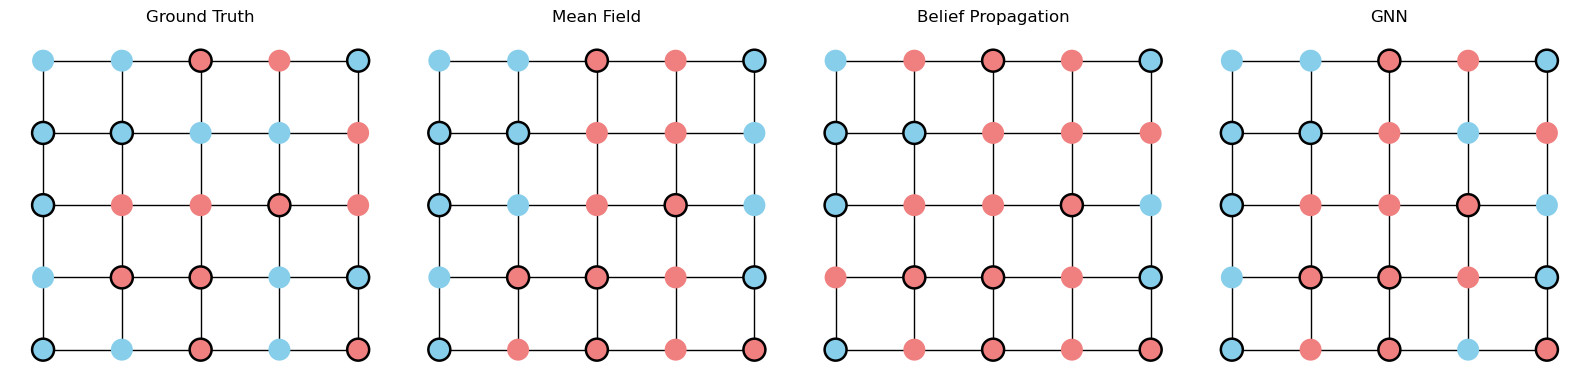

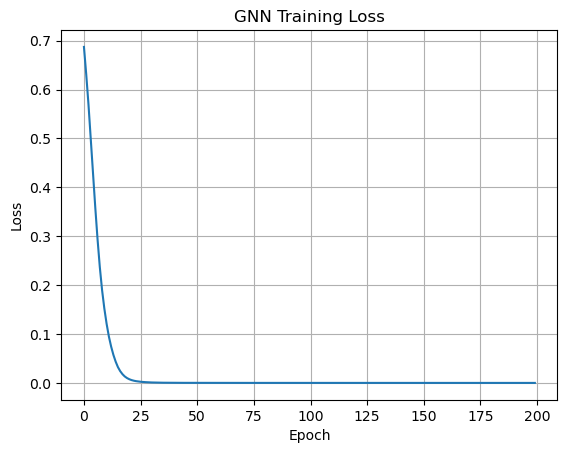


--- Accuracy on Unlabeled Nodes ---
Mean Field Accuracy         : 0.385
Belief Propagation Accuracy : 0.385
GNN Accuracy                : 0.692


In [2]:
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

import os

os.makedirs("figs", exist_ok=True)

# --- PARAMETERS ---
grid_size = 5
visible_fraction = 0.5
ising_beta = 0.5

# --- GRID GRAPH ---
G = nx.grid_2d_graph(grid_size, grid_size)
nodes = list(G.nodes())
n = len(nodes)
node_to_idx = {node: i for i, node in enumerate(nodes)}
idx_to_node = {i: node for node, i in node_to_idx.items()}
adj = nx.adjacency_matrix(G).toarray()
A = torch.tensor(adj, dtype=torch.float32)

# --- VISIBLE/LABELED INDICES ---
visible_count = int(visible_fraction * n)
labeled_idx = sorted(random.sample(range(n), visible_count))
unlabeled_idx = [i for i in range(n) if i not in labeled_idx]

# --- GIBBS SAMPLING WITH CONSTRAINTS ---
def gibbs_sample_with_constraints(adj, beta, y_init, known_idx, num_iters=200):
    y = y_init.clone()
    for _ in range(num_iters):
        for i in range(len(y)):
            if i in known_idx:
                continue
            neighbors = torch.where(adj[i] > 0)[0]
            field = beta * torch.sum(y[neighbors])
            prob = torch.sigmoid(2 * field)
            y[i] = 1 if torch.rand(1).item() < prob else -1
    return y

y_init = torch.tensor(np.random.choice([-1, 1], size=(n,)), dtype=torch.float32)
for i in labeled_idx:
    y_init[i] = torch.tensor(np.random.choice([-1, 1]))

y_true = gibbs_sample_with_constraints(A, ising_beta, y_init, labeled_idx)
y_train = y_true[labeled_idx]
X = torch.eye(n)

# --- MEAN FIELD ---
def mean_field(adj, labels, known_idx, iters=5):
    probs = torch.full((len(labels),), 0.5)
    for i in known_idx:
        probs[i] = 1.0 if labels[i] == 1 else 0.0
    for _ in range(iters):
        probs_new = probs.clone()
        for i in range(len(labels)):
            if i in known_idx:
                continue
            neighbors = torch.where(adj[i] > 0)[0]
            msg = torch.sum(2 * probs[neighbors] - 1)
            probs_new[i] = torch.sigmoid(2.0 * msg)
        probs = probs_new
    return probs

# --- BELIEF PROPAGATION ---
def belief_propagation(adj, labels, known_idx, iters=5):
    n = len(labels)
    messages = torch.zeros((n, n))
    for i in known_idx:
        for j in range(n):
            if adj[i, j] > 0:
                messages[i, j] = 2 * labels[i]
    for _ in range(iters):
        new_messages = torch.zeros_like(messages)
        for i in range(n):
            for j in range(n):
                if adj[i, j] == 0 or i == j:
                    continue
                msg_sum = sum(messages[k, i] for k in range(n) if k != j and adj[k, i] > 0)
                new_messages[i, j] = msg_sum
        messages = new_messages
    beliefs = torch.sum(messages, dim=0)
    probs = torch.sigmoid(beliefs)
    for i in known_idx:
        probs[i] = 1.0 if labels[i] == 1 else 0.0
    return probs

# --- SIMPLE GNN ---
class SimpleGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=16, out_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, adj):
        x = F.relu(self.fc1(x))
        x = torch.matmul(adj, x)
        x = self.fc2(x)
        return x

# --- TRAIN GNN ---
gnn = SimpleGNN(in_dim=n)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.05)
loss_fn = nn.BCEWithLogitsLoss()
loss_history = []

for epoch in range(200):
    gnn.train()
    out = gnn(X, A).squeeze()
    loss = loss_fn(out[labeled_idx], (y_train + 1) / 2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# --- INFERENCE ---
mf_probs = mean_field(A, y_true, labeled_idx)
bp_probs = belief_propagation(A, y_true, labeled_idx)
gnn.eval()
with torch.no_grad():
    logits = gnn(X, A).squeeze()
    gnn_probs = torch.sigmoid(logits)

mf_labels = torch.sign(mf_probs - 0.5)
bp_labels = torch.sign(bp_probs - 0.5)
gnn_labels = torch.sign(gnn_probs - 0.5)

# --- ACCURACY ON UNLABELED NODES ---
def accuracy(pred, true, idx):
    return (pred[idx] == true[idx]).float().mean().item()

mf_acc = accuracy(mf_labels, y_true, unlabeled_idx)
bp_acc = accuracy(bp_labels, y_true, unlabeled_idx)
gnn_acc = accuracy(gnn_labels, y_true, unlabeled_idx)

# --- VISUALIZATION ---
# Save the figure showing GT, MF, BP, and GNN
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
pos = {node: node for node in G.nodes()}
label_sets = [y_true, mf_labels, bp_labels, gnn_labels]
titles = ['Ground Truth', 'Mean Field', 'Belief Propagation', 'GNN']

for ax, labels, title in zip(axes, label_sets, titles):
    color_map = ['lightcoral' if labels[i] == -1 else 'skyblue' for i in range(n)]
    border = ['black' if i in labeled_idx else 'none' for i in range(n)]
    nx.draw(G, pos=pos, ax=ax, node_color=color_map,
            edgecolors=border, linewidths=1.8, node_size=250, with_labels=False)
    ax.set_title(title)

plt.tight_layout()
plt.savefig("figs/inference_comparison_grid.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()


# --- LOSS PLOT ---
plt.figure()
plt.plot(loss_history)
plt.title("GNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- PRINT ACCURACY ---
print("\n--- Accuracy on Unlabeled Nodes ---")
print(f"Mean Field Accuracy         : {mf_acc:.3f}")
print(f"Belief Propagation Accuracy : {bp_acc:.3f}")
print(f"GNN Accuracy                : {gnn_acc:.3f}")

## Summary
This notebook illustrates how GNNs can be viewed as **learned, amortized inference procedures**, closely related in structure to classical mean-field and belief propagation algorithms, but optimized directly for predictive performance.